# PrimeurVision — Fine-tuning YOLOv8

Fine-tuning d'un modèle **YOLOv8n pré-entraîné sur COCO** pour détecter 6 classes de fruits et légumes en contexte culinaire.

**Stratégie d'entraînement en 2 phases :**
1. **Backbone gelé** : seule la tête de détection est entraînée — on adapte rapidement le modèle à nos classes sans perturber les features générales apprises sur COCO.
2. **Fine-tuning complet** : on dégèle tout le réseau et on affine avec un learning rate plus faible — permet d'optimiser finement toutes les couches sur notre domaine.

**Classes** : carotte (0), aubergine (1), citron (2), pomme_de_terre (3), radis (4), tomate (5)

**Dataset** : 238 images — 166 train / 36 val / 36 test

## 1. Installation des dépendances

In [1]:
!pip install ultralytics -q

## 2. Imports

In [2]:
import os
import shutil
import random
import glob
import yaml
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from ultralytics import YOLO

## 3. Hyperparamètres

| Paramètre | Phase 1 | Phase 2 | Justification |
|---|---|---|---|
| Modèle | YOLOv8s | YOLOv8s | Small (11M params) vs Nano (3M) — plus de capacité sans exploser le temps d'entraînement |
| Epochs | 10 | 80 | Phase 2 allongée + early stopping pour affinage fin |
| Learning rate | 1e-2 | 1e-3 | LR élevé pour adapter vite la tête ; LR faible pour ne pas écraser les features |
| Freeze | 10 couches | 0 | Backbone gelé en phase 1, tout libéré en phase 2 |
| Batch size | 16 | 16 | Compromis mémoire/stabilité des gradients |
| Image size | 640 | 640 | Taille standard YOLOv8, bon compromis précision/vitesse |
| Patience | 10 | 20 | Early stopping élargi en phase 2 pour laisser le modèle converger |
| Rotation | ±15° | ±15° | Augmentation : le modèle doit détecter sous différents angles |
| Flip vertical | 0.3 | 0.3 | Augmentation : robustesse aux orientations inhabituelles |
| Mixup | 0.1 | 0.1 | Mélange léger d'images pour réduire l'overfitting |
| Label smoothing | 0.1 | 0.1 | Régularisation : limite la sur-confiance sur les annotations bruitées |

In [ ]:
import os
import torch

# Fix MPS : certaines opérations d'indexing avancé ne sont pas supportées nativement
# Ce flag fait retomber ces opérations sur CPU automatiquement
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# --- MODÈLE ---
MODEL_NAME = 'yolov8s.pt'          # small (11M params) au lieu de nano (3M)

# Détection automatique du device
DEVICE = 'mps'  if torch.backends.mps.is_available() else \
         'cuda' if torch.cuda.is_available()          else 'cpu'
print(f"Device : {DEVICE}")

# --- HYPERPARAMÈTRES ---

# Phase 1 : backbone gelé
PHASE1_EPOCHS  = 10
PHASE1_LR      = 1e-2
FREEZE_LAYERS  = 10

# Phase 2 : fine-tuning complet
PHASE2_EPOCHS  = 80
PHASE2_LR      = 1e-3

# Paramètres communs
IMG_SIZE       = 640
BATCH_SIZE     = 16
PATIENCE_P1    = 10
PATIENCE_P2    = 20
CONF_THRESHOLD = 0.25

# Augmentation renforcée
AUG_DEGREES    = 15
AUG_FLIPUD     = 0.3
AUG_MIXUP      = 0.1
LABEL_SMOOTH   = 0.1

## 4. Chargement du dataset

**Colab** : monte Google Drive et copie le dataset en local.  
**Local** : utilise directement le dossier `dataset/` du projet.

In [4]:
import sys

ON_COLAB = 'google.colab' in sys.modules or 'google.colab' in str(sys.path)

if ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATASET_SRC = '/content/drive/MyDrive/PrimeurVision/dataset'
    WORK_DIR    = '/content/dataset'
    MODELS_DIR  = '/content/drive/MyDrive/PrimeurVision/models'
    # Copie en local pour accélérer l'entraînement
    if os.path.exists(WORK_DIR):
        shutil.rmtree(WORK_DIR)
    shutil.copytree(DATASET_SRC, WORK_DIR)
else:
    # Exécution locale — dataset déjà présent dans le dépôt
    PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
    WORK_DIR     = os.path.join(PROJECT_ROOT, 'dataset')
    MODELS_DIR   = os.path.join(PROJECT_ROOT, 'models')
    os.makedirs(MODELS_DIR, exist_ok=True)
    print(f"Mode local — dataset : {WORK_DIR}")

# Charger et mettre à jour la config avec les chemins locaux
data_yaml_path = os.path.join(WORK_DIR, 'data.yaml')
with open(data_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

data_config['path']  = WORK_DIR
data_config['train'] = 'images/train'
data_config['val']   = 'images/val'
data_config['test']  = 'images/test'
with open(data_yaml_path, 'w') as f:
    yaml.dump(data_config, f, default_flow_style=False)

CLASS_NAMES = data_config['names']
NUM_CLASSES = len(CLASS_NAMES)

print(f"{NUM_CLASSES} classes : {list(CLASS_NAMES.values())}")
for split in ['train', 'val', 'test']:
    img_dir = os.path.join(WORK_DIR, 'images', split)
    if os.path.exists(img_dir):
        print(f"  {split}: {len(os.listdir(img_dir))} images")

Mode local — dataset : /Users/eugenie/Desktop/M2-SISE/13 - Deep learning - Machine learning - Computer Vision/projet_computer_vision/dataset
6 classes : ['carotte', 'aubergine', 'citron', 'pomme_de_terre', 'radis', 'tomate']
  train: 166 images
  val: 36 images
  test: 36 images


## 5. Exploration du dataset

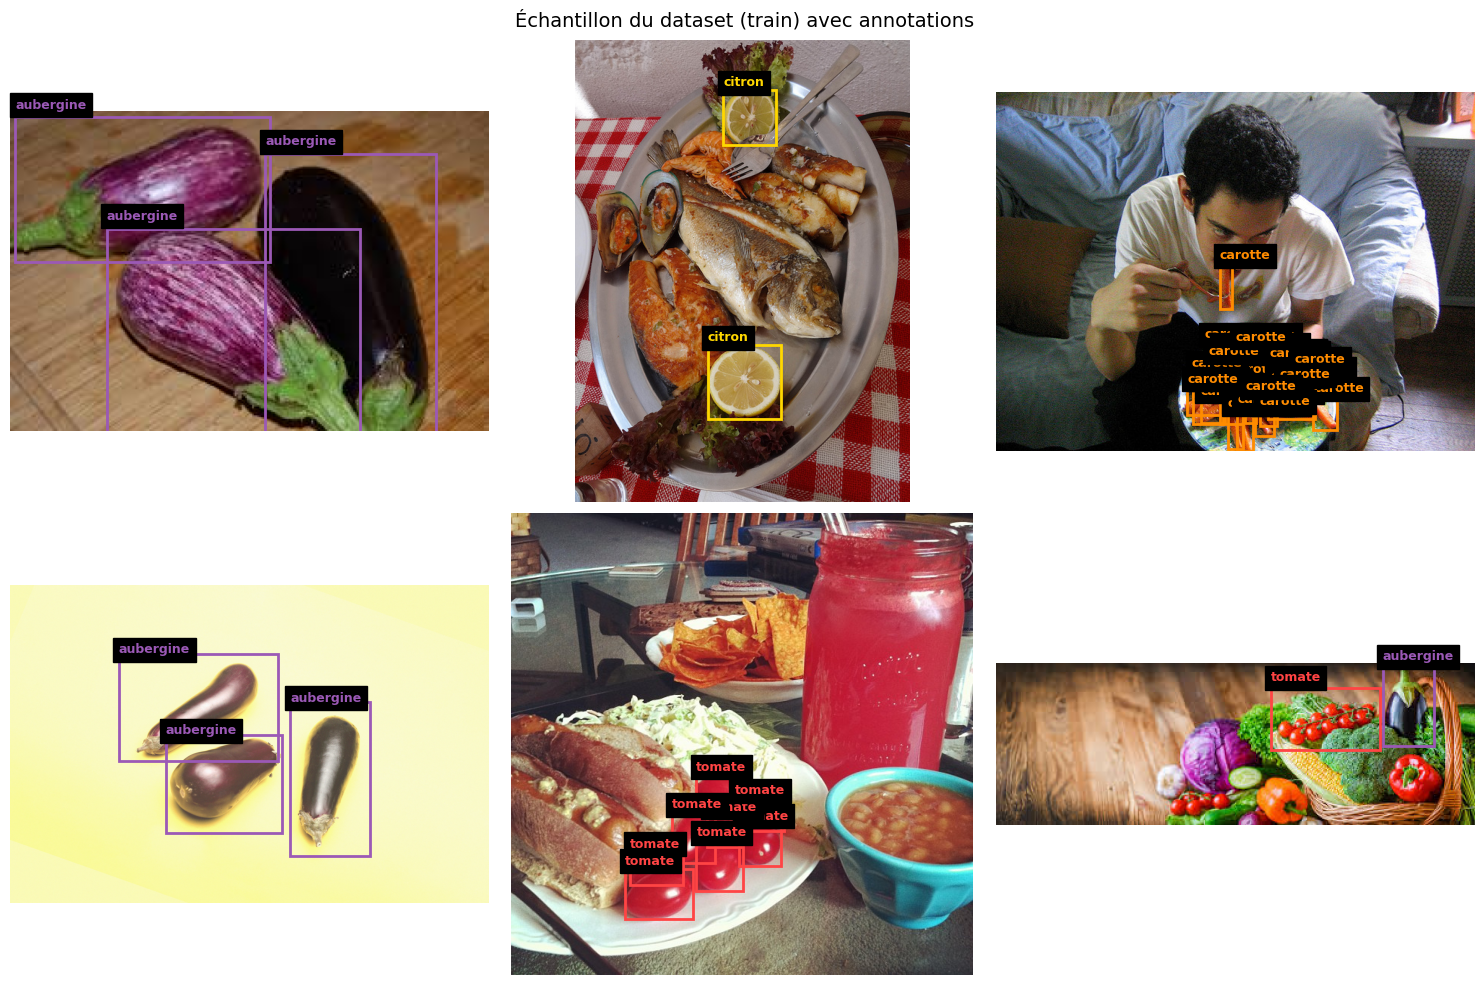

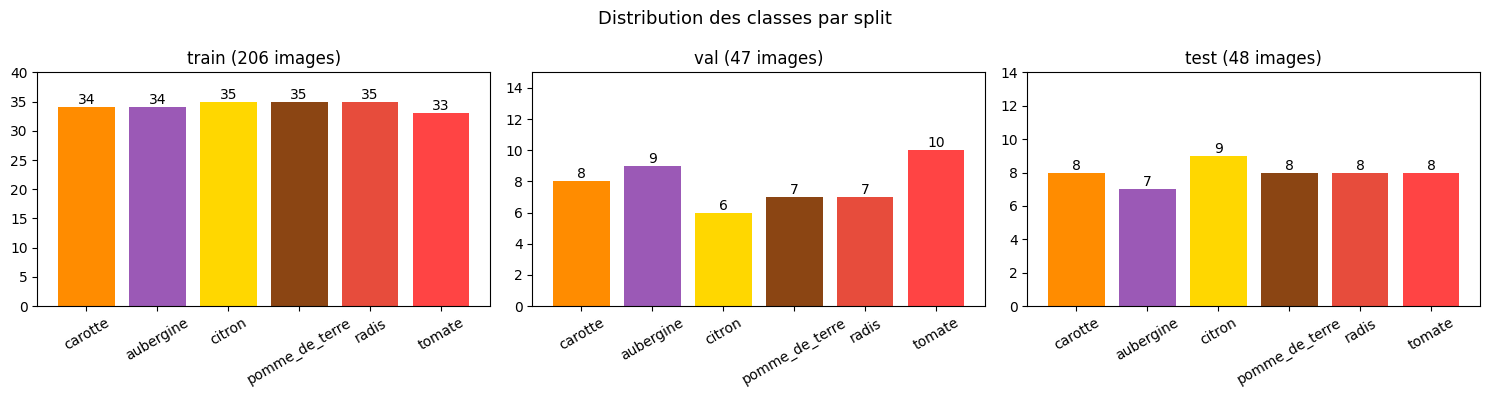

In [5]:
COLORS = ['#FF8C00', '#9B59B6', '#FFD700', '#8B4513', '#E74C3C', '#FF4444']

def parse_yolo_label(label_path):
    annotations = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])
                annotations.append((class_id, x_center, y_center, width, height))
    return annotations

def plot_image_with_boxes(img_path, label_path, ax):
    img = Image.open(img_path)
    w, h = img.size
    ax.imshow(img)
    for class_id, xc, yc, bw, bh in parse_yolo_label(label_path):
        x1 = (xc - bw / 2) * w
        y1 = (yc - bh / 2) * h
        color = COLORS[class_id % len(COLORS)]
        rect = patches.Rectangle((x1, y1), bw * w, bh * h,
                                  linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, CLASS_NAMES.get(class_id, '?'), color=color,
                fontsize=9, fontweight='bold', backgroundcolor='black')
    ax.axis('off')

# 6 images aléatoires du train avec leurs bounding boxes
train_images_dir = os.path.join(WORK_DIR, 'images', 'train')
train_labels_dir = os.path.join(WORK_DIR, 'labels', 'train')
image_files   = sorted(glob.glob(os.path.join(train_images_dir, '*.jpg')))
sample_images = random.sample(image_files, min(6, len(image_files)))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, img_path in zip(axes.flatten(), sample_images):
    base_name  = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(train_labels_dir, base_name + '.txt')
    if os.path.exists(label_path):
        plot_image_with_boxes(img_path, label_path, ax)
plt.suptitle('Échantillon du dataset (train) avec annotations', fontsize=14)
plt.tight_layout()
plt.show()

# Distribution des classes (nb images par classe par split)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, split in zip(axes, ['train', 'val', 'test']):
    labels_dir   = os.path.join(WORK_DIR, 'labels', split)
    class_counts = {v: 0 for v in CLASS_NAMES.values()}
    for lf in glob.glob(os.path.join(labels_dir, '*.txt')):
        seen = set()
        for class_id, *_ in parse_yolo_label(lf):
            name = CLASS_NAMES.get(class_id)
            if name and name not in seen:
                class_counts[name] += 1
                seen.add(name)
    bars = ax.bar(class_counts.keys(), class_counts.values(), color=COLORS)
    ax.bar_label(bars)
    ax.set_title(f'{split} ({sum(class_counts.values())} images)')
    ax.set_ylim(0, max(class_counts.values()) + 5)
    ax.tick_params(axis='x', rotation=30)
plt.suptitle('Distribution des classes par split', fontsize=13)
plt.tight_layout()
plt.show()

## 6. Entraînement en 2 phases

### Phase 1 — Backbone gelé

On charge YOLOv8n pré-entraîné sur COCO et on gèle les 10 premières couches (backbone CSP-DarkNet). Seule la tête de détection apprend. Cette approche permet :
- D'éviter le *catastrophic forgetting* des features génériques (bords, textures, formes)
- D'obtenir une convergence rapide sur nos classes cibles
- De réduire le risque d'overfitting avec notre petit dataset (~166 images train)

In [6]:
model = YOLO(MODEL_NAME)

results_phase1 = model.train(
    data=data_yaml_path,
    epochs=PHASE1_EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    lr0=PHASE1_LR,
    freeze=FREEZE_LAYERS,
    name='primeurvision_v2_phase1',
    patience=PATIENCE_P1,
    save=True,
    plots=True,
    verbose=True,
    device=DEVICE,
    degrees=AUG_DEGREES,
    flipud=AUG_FLIPUD,
    mixup=AUG_MIXUP,
    label_smoothing=LABEL_SMOOTH,
)

WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in the future.
Ultralytics 8.4.14 🚀 Python-3.11.14 torch-2.10.0 MPS (Apple M3)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/eugenie/Desktop/M2-SISE/13 - Deep learning - Machine learning - Computer Vision/projet_computer_vision/dataset/data.yaml, degrees=15, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.3, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8s.pt, momentum=0.

### Phase 2 — Fine-tuning complet

On reprend le meilleur modèle de la phase 1 et on dégèle toutes les couches. Le learning rate est réduit d'un facteur 10 pour affiner les poids sans écraser les représentations apprises lors de la phase 1.

In [7]:
best_phase1 = os.path.join('runs', 'detect', 'primeurvision_v2_phase1', 'weights', 'best.pt')
model = YOLO(best_phase1)

results_phase2 = model.train(
    data=data_yaml_path,
    epochs=PHASE2_EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    lr0=PHASE2_LR,
    freeze=0,
    name='primeurvision_v2_phase2',
    patience=PATIENCE_P2,
    save=True,
    plots=True,
    verbose=True,
    device=DEVICE,
    degrees=AUG_DEGREES,
    flipud=AUG_FLIPUD,
    mixup=AUG_MIXUP,
    label_smoothing=LABEL_SMOOTH,
)

RESULTS_DIR = os.path.join('runs', 'detect', 'primeurvision_v2_phase2')

WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in the future.
Ultralytics 8.4.14 🚀 Python-3.11.14 torch-2.10.0 MPS (Apple M3)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/eugenie/Desktop/M2-SISE/13 - Deep learning - Machine learning - Computer Vision/projet_computer_vision/dataset/data.yaml, degrees=15, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.3, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=runs/detect/primeurvisi

AcceleratorError: index 5120 is out of bounds: 0, range 0 to 16

## 7. Courbes d'entraînement et résultats sur la validation

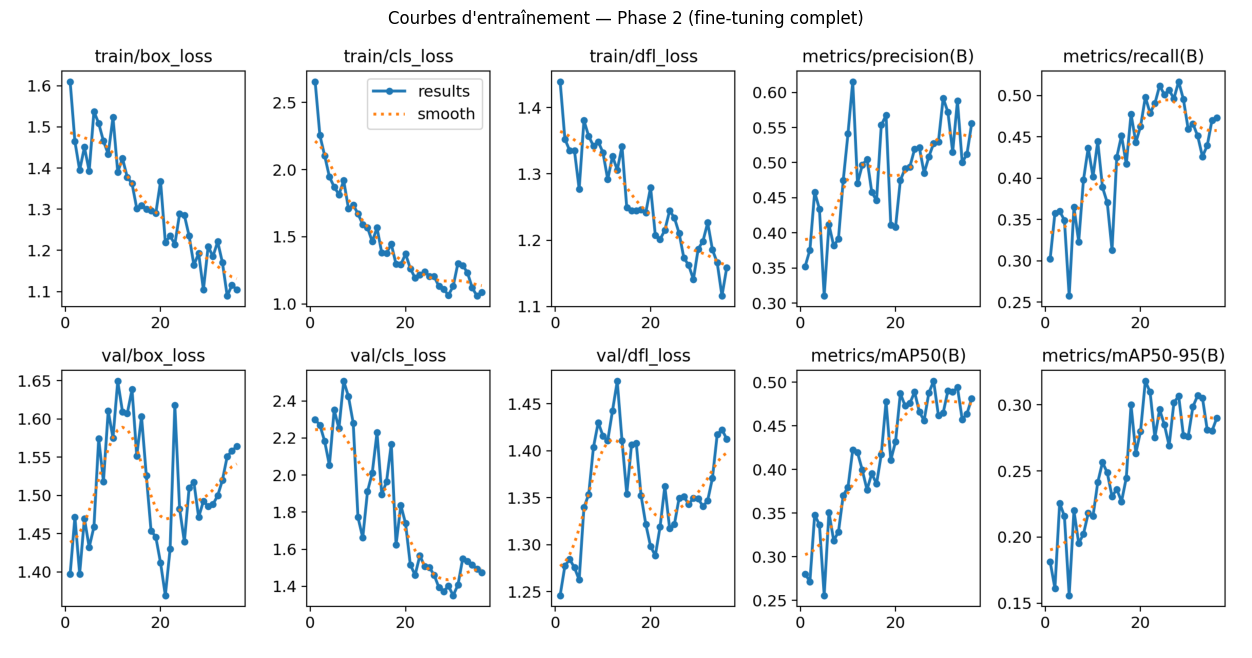

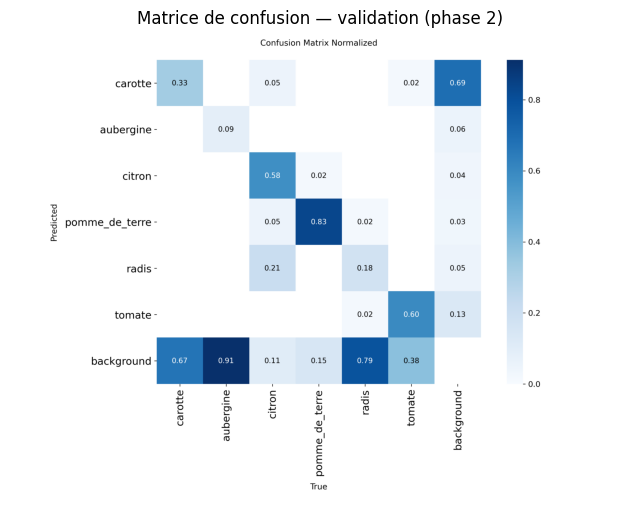

Ultralytics 8.4.14 🚀 Python-3.11.14 torch-2.10.0 CPU (Apple M3)
Model summary (fused): 73 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3873.3±2870.8 MB/s, size: 707.7 KB)
val: Scanning /Users/eugenie/Desktop/M2-SISE/13 - Deep learning - Machine learning - Computer Vision/projet_computer_vision/dataset/labels/val.cache... 36 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 36/36 50.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.6s/it 4.8s4.2ss
                   all         36        555      0.533      0.462      0.493      0.324
               carotte          8        199      0.268      0.331      0.248      0.122
             aubergine          9         57      0.388      0.158      0.119     0.0537
                citron          6         19      0.579      0.653      0.846       0.66
        pomme_de_terre          7         54      0.823 

In [ ]:
# Courbes loss + mAP au fil des epochs (phase 2)
results_img = os.path.join(RESULTS_DIR, 'results.png')
if os.path.exists(results_img):
    plt.figure(figsize=(18, 8))
    plt.imshow(Image.open(results_img))
    plt.axis('off')
    plt.title("Courbes d'entraînement — Phase 2 (fine-tuning complet)")
    plt.show()

# Matrice de confusion normalisée (validation)
for fname in ['confusion_matrix_normalized.png', 'confusion_matrix.png']:
    confusion_img = os.path.join(RESULTS_DIR, fname)
    if os.path.exists(confusion_img):
        plt.figure(figsize=(8, 8))
        plt.imshow(Image.open(confusion_img))
        plt.axis('off')
        plt.title('Matrice de confusion — validation (phase 2)')
        plt.show()
        break

# Courbe Précision-Rappel
pr_img = os.path.join(RESULTS_DIR, 'PR_curve.png')
if os.path.exists(pr_img):
    plt.figure(figsize=(10, 6))
    plt.imshow(Image.open(pr_img))
    plt.axis('off')
    plt.title('Courbe Précision-Rappel par classe')
    plt.show()

# Métriques finales sur la validation
metrics_val = model.val(data=data_yaml_path, split='val')
print("\n=== Résultats sur la validation (phase 2) ===")
print(f"  mAP@50    : {metrics_val.box.map50:.4f}")
print(f"  mAP@50-95 : {metrics_val.box.map:.4f}")
print(f"  Précision : {metrics_val.box.mp:.4f}")
print(f"  Recall    : {metrics_val.box.mr:.4f}")
print("\nAP@50 par classe :")
for i, name in CLASS_NAMES.items():
    ap = metrics_val.box.ap50[i] if i < len(metrics_val.box.ap50) else 0
    print(f"  {name:20s} : {ap:.4f}")

## 8. Sauvegarde du modèle

In [ ]:
os.makedirs(MODELS_DIR, exist_ok=True)

# Meilleur modèle v2
best_model_path = os.path.join(RESULTS_DIR, 'weights', 'best.pt')
dest_model      = os.path.join(MODELS_DIR, 'best_yolov8s_primeurvision_v2.pt')
shutil.copy2(best_model_path, dest_model)

# Courbes et figures pour le rapport
for fname in ['results.png', 'confusion_matrix.png', 'confusion_matrix_normalized.png',
              'PR_curve.png', 'F1_curve.png']:
    src = os.path.join(RESULTS_DIR, fname)
    if os.path.exists(src):
        shutil.copy2(src, os.path.join(MODELS_DIR, fname))

print(f"Modèle et courbes sauvegardés dans : {MODELS_DIR}")
print(f"  → best_yolov8s_primeurvision_v2.pt")